# Email Template Classification


by Anat Karny

## Introduction

This project classifies e-mails into 3 pre-defined classes. 

## Imports and Global Definitions

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers.noise import GaussianNoise
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import layers
from tensorflow.python.keras.utils.vis_utils import plot_model
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# Define colors for the project's plots.
label_colors = ["#F58C41", "#2FAFC6", "#800080", "#AF1946", 
                "#46A5E1", "#522A64", "#A3DB05", "#FC6514"]

In [3]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Data Loading and Exploration

I created synthetic data using https://mockaroo.com/. The data contane three types of mails: 1)Restaurant Table Reservation (RR) 2)Online product order confirmation (MO) 3)Private emails (PM)


In [4]:
df= pd.read_csv('DL_EMAIL_DATA.csv')
email_df=df
email_df.head()

,id,MAIL_SUBJECT,SENDER,TOP_TEXT,TEXT,HTML_TAG_COUNT,LINK_TAG_COUNT,DATETIME_COUNT,LABEL,IS_RR,IS_MO,IS_PM
0,1.0,Quisque reservation at Dickens-Walsh,Dickens-Walsh,reservation Number: 3325 reservation Status: ...,Quisque reservation at Dickens-Walsh reserv...,1,5,2,RR,1,0,0
1,2.0,"Quisque reservation at Mann, Bernhard and Ba...","Mann, Bernhard and Balistreri",reservation Number: 72148 reservation Status:...,"Quisque reservation at Mann, Bernhard and Ba...",0,2,1,RR,1,0,0
2,3.0,Cras reservation at Dietrich Group,Dietrich Group,reservation Number: 78231 reservation Status:...,Cras reservation at Dietrich Group reservat...,1,5,2,RR,1,0,0
3,4.0,"reservation at Buckridge, Rutherford and Bau...","Buckridge, Rutherford and Baumbach",Vivamus vel nulla eros elementum pellentesque...,"reservation at Buckridge, Rutherford and Bau...",1,2,2,RR,1,0,0
4,5.0,"Duis reservation at Veum, Ebert and Kutch","Veum, Ebert and Kutch",Praesent blandit lacinia erat. Vestibulum sed ...,"Duis reservation at Veum, Ebert and Kutch Pr...",1,5,2,RR,1,0,0


Create Dictionaries and cleaning up the data

In [5]:
col = ['TEXT', 'LABEL']
email_df = email_df[col]
email_df = email_df[pd.notnull(email_df['TEXT'])]
email_df.columns = ['TEXT', 'LABEL']
email_df['cluster_id'] = email_df['LABEL'].factorize()[0]
cluster_id_df = email_df[['LABEL', 'cluster_id']].drop_duplicates().sort_values('cluster_id')
cluster_to_id = dict(cluster_id_df.values)
id_to_cluster = dict(cluster_id_df[['cluster_id', 'LABEL']].values)
email_df.head()

,TEXT,LABEL,cluster_id
0,Quisque reservation at Dickens-Walsh reserv...,RR,0
1,"Quisque reservation at Mann, Bernhard and Ba...",RR,0
2,Cras reservation at Dietrich Group reservat...,RR,0
3,"reservation at Buckridge, Rutherford and Bau...",RR,0
4,"Duis reservation at Veum, Ebert and Kutch Pr...",RR,0


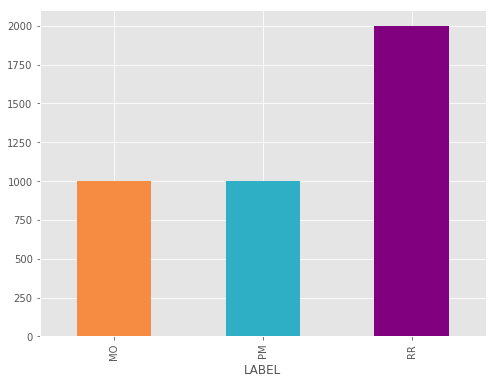

In [6]:
fig = plt.figure(figsize=(8,6))
email_df.groupby('LABEL').TEXT.count().plot.bar(ylim=0,color=label_colors)
plt.show()

Imbalanced Classes - We see that the number of complaints per product is imbalanced.

## Split the data to test, train and validation

In [7]:
data_train, data_test = train_test_split(df, test_size=0.2,random_state=1)
data_train, data_valid = train_test_split(data_train, test_size=0.2,random_state=1)
print("Size of:")
print("* Training-set:\t\t{}".format(len(data_train)))
print("* Validation-set:\t{}".format(len(data_valid)))
print("* Test-set:\t\t{}".format(len(data_test)))

Size of:
* Training-set:		2560
* Validation-set:	640
* Test-set:		800


## Text Representation - TF-IDF
For each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf

In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=400, norm='l2',  ngram_range=(1,3), 
                        stop_words='english')
features = tfidf.fit_transform(email_df.TEXT).toarray()
labels = email_df.cluster_id
featur_size = len(features[0])
features.shape
#print(features[2347])

(4000, 200)

each of 4000 e-mails  is represented by 463 features, representing the tf-idf score for different unigrams and bigrams.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features,df['IS_RR'], test_size=0.2,random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2,random_state=1)
print("Size of:")
print("* Training-set:\t\t{}".format(len(X_train)))
print("* Validation-set:\t{}".format(len(X_valid)))
print("* Test-set:\t\t{}".format(len(X_test)))

Size of:
* Training-set:		2560
* Validation-set:	640
* Test-set:		800


## Sequential Model

In [10]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
model.add(Dense(20, input_dim=featur_size))
model.add(Dense(20,activation='relu'))
model.add(GaussianNoise(0.2))
model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1, activation='relu'))



### Model Compilation

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                4020      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
__________

## Training

In [12]:
history_tfidf = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=10,verbose=False)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 1.0000


### Evaluation

In [13]:
result = model.evaluate(x=X_valid,y=y_valid,verbose=False)
print("Validation Accuracy: {:.4f}".format(result[1]))

Validation Accuracy: 1.0000


### Prediction

In [14]:
y_pred = (model.predict(x=X_test) > 0.5).astype(np.int)

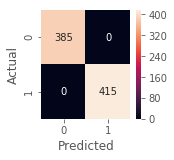

In [15]:
conf_mat=confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(2,2))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Data Representation - Word Embeddings
Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information.

In [16]:
sentences_train = data_train['TEXT']
sentences_valid = data_valid['TEXT']
sentences_test = data_test['TEXT']
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_valid = tokenizer.texts_to_sequences(sentences_valid)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[:1])
print(X_train[1])

#One problem that we have is that each text sequence has different length.
#To counter this we pad the sequence of words with zeros.
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[1])

3389     Order from Ankunding-Turner  orderNumber: 389...
Name: TEXT, dtype: object
[62, 70, 72, 4, 100]
[ 62  70  72   4 100   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Sequential Model

In [17]:
embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
#model.add(layers.Flatten())
model.add(LSTM(100))
#model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


### Model Compilation

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           566650    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 628,071
Trainable params: 628,071
Non-trainable params: 0
_________________________________________________________________


## Training

In [19]:
y_train = data_train['IS_RR']
y_test = data_test['IS_RR']
y_valid = data_valid['IS_RR']
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_valid, y_valid),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.8562


### Evaluation

In [20]:
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8484


### Prediction

In [21]:
y_pred2 = (model.predict(x=X_test) > 0.5).astype(np.int)

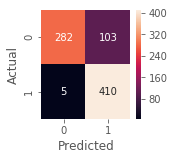

In [22]:
conf_mat=confusion_matrix(y_test, y_pred2)
fig, ax = plt.subplots(figsize=(2,2))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### TF-IDF

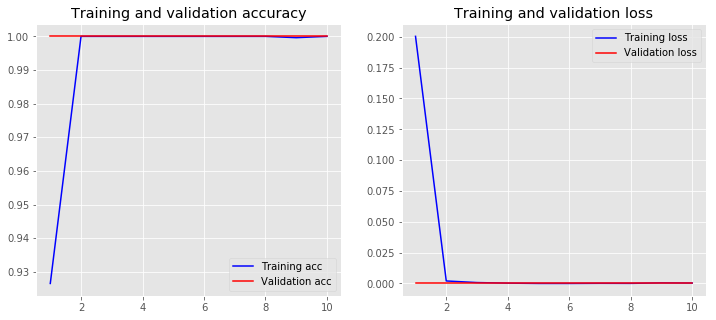

In [23]:
plot_history(history_tfidf)
#plot_model(model, show_shapes=True, show_layer_names=True)


## Word Embeddings

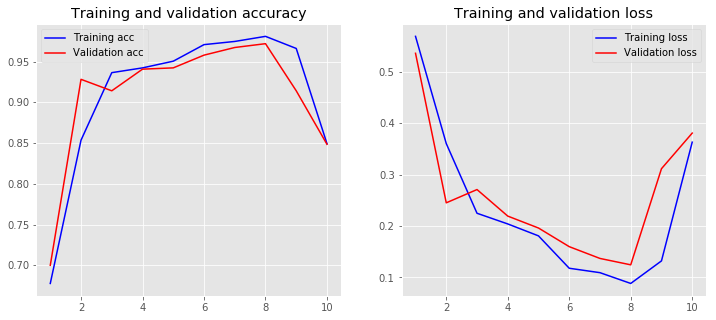

In [24]:
plot_history(history)